In [1]:
import os
from PIL import Image, ImageDraw

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.ndimage import morphology
from scipy.stats import multivariate_normal

import cv2

import img_manip

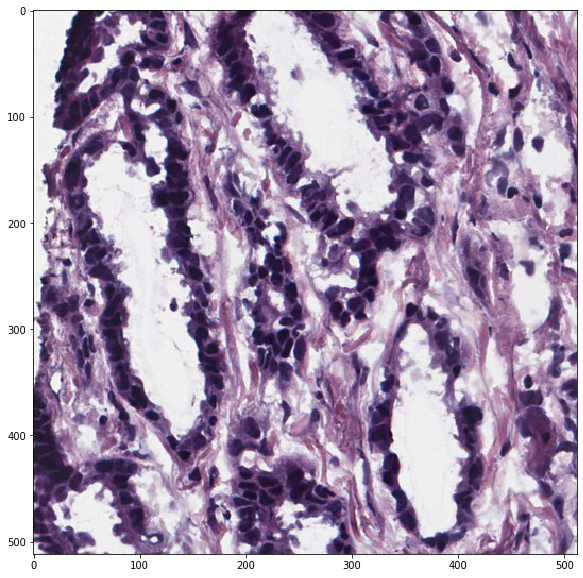

<class 'PIL.JpegImagePlugin.JpegImageFile'> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x1A1BF85DA0>


In [2]:
cDir = os.path.join('..','work','intermediate','LUAD_0','tiles','TCGA-MP-A4T6-01A-03-TSC.DC283477-48E1-4EB5-AC22-B73FFFA34CC3_files',
                   '20.0')
# 'work/intermediate/LUAD_0/tiles/TCGA-MP-A4T6-01A-03-TSC.DC283477-48E1-4EB5-AC22-B73FFFA34CC3_files/20.0/4_15.jpeg'
cFile = os.path.join(cDir,'4_15.jpeg')
im = Image.open(cFile)
fig,ax = plt.subplots(figsize=(15, 10))
plt.imshow(im)
plt.show()
dim = im.size
print(type(im),im)

[[-0.0640051  -0.47407377]] [[ 0.66224686 -0.03611182]
 [-0.03611182  0.57649179]]
[[-0.16966518 -0.29535137]] [[ 0.71445322 -0.15817516]
 [-0.15817516  0.47474101]]


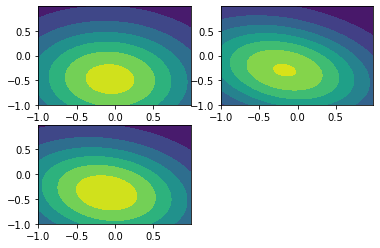

In [27]:
np.random.seed(seed=2)
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
cent1 = np.random.uniform(-.5,.5,size=(1,2))

cov1 = np.zeros((2,2))
# need to make a symmetric positive semidefinite covariance matrix
cov1 = np.diag(np.random.uniform(.25,1,size=(1,2)).flatten())
cov1[[0,1],[1,0]] = np.random.uniform(-np.product(np.diag(cov2)),np.product(np.diag(cov1))) 
print(cent1,cov1)

cent2 = np.random.uniform(-.5,.5,size=(1,2))
cov2 = np.zeros((2,2))
# need to make a symmetric positive semidefinite covariance matrix
cov2 = np.diag(np.random.uniform(.25,1,size=(1,2)).flatten())
cov2[[0,1],[1,0]] = np.random.uniform(-np.product(np.diag(cov2)),np.product(np.diag(cov2))) 
print(cent2,cov2)

rv1 = multivariate_normal(cent1.flatten(), cov1)
rv2 = multivariate_normal(cent2.flatten(), cov2)
fig2 = plt.figure()
ax2 = fig2.add_subplot(221)
ax2.contourf(x, y, rv1.pdf(pos))
ax2 = fig2.add_subplot(222)
ax2.contourf(x, y, rv2.pdf(pos))
ax2 = fig2.add_subplot(223)
ax2.imshow(im)
plt.show()

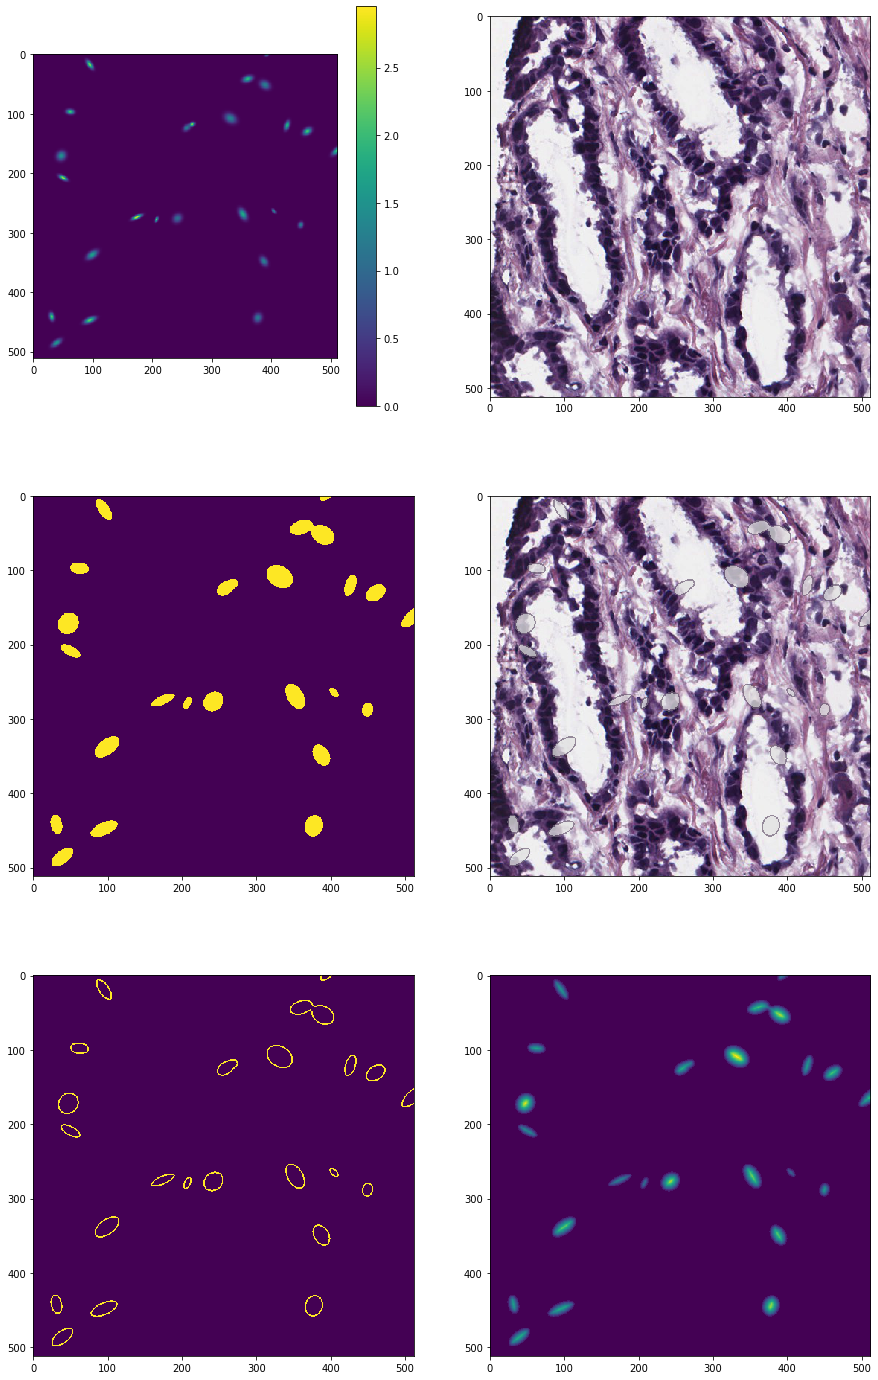

In [108]:
np.random.seed(seed=0)
invDim = (dim[1],dim[0])
maxWidth = 50
maxCov = maxWidth^2
nNorms = 25
alpha = .75
edge_thresh = 2
xM, yM = np.mgrid[range(dim[0]),range(dim[1])]
pos = np.dstack((xM, yM))
sumMap = np.zeros(invDim)
for i in range(nNorms):
    cent = np.concatenate((np.random.randint(invDim[0],size=(1,1)),
                        np.random.randint(invDim[1],size=(1,1))), axis=1)
    cov = np.zeros((2,2))
    # need to make a symmetric positive semidefinite covariance matrix
    cMaxCov = np.random.uniform(maxCov/10,maxCov,size=(1,1))
    cov = np.diag(np.random.uniform(cMaxCov/4,cMaxCov,size=(1,2)).flatten())
    maxCrCov = np.sqrt(np.product(np.diag(cov)))
    cov[[0,1],[1,0]] = np.random.uniform(-maxCrCov*.7,maxCrCov*.7) 
    rv = multivariate_normal(cent.flatten(), cov)
#     print((cMaxCov * 2 * np.pi))
    sumMap += (rv.pdf(pos) * (cMaxCov * 2 * np.pi))

    
bw_reg = sumMap >= (1/maxCov)
# mask = 1-bw_reg # invert the mask
bw_dist = morphology.distance_transform_edt(bw_reg)
edge_area = np.logical_and(bw_dist <= edge_thresh,bw_reg)

alpha_mask = Image.fromarray((bw_reg*alpha*255).astype(np.uint8),'L')
color_arr = np.zeros((dim[0],dim[1],3),dtype=np.uint8)
rgbVal = (225,225,225)
meanColor = np.mean(np.array(im),axis=(0,1))
for i in range(len(rgbVal)):
    color_arr[:,:,i] = rgbVal[i]
    color_arr[edge_area,i] = np.uint8(meanColor[i] * .75)
    
color_layer = Image.fromarray(color_arr,'RGB')
comp_im = Image.composite(color_layer, im, alpha_mask)

fig2 = plt.figure(figsize=(15,25))
ax2 = fig2.add_subplot(321)
plt.imshow(sumMap)
plt.colorbar()
ax2 = fig2.add_subplot(322)
ax2.imshow(im)
ax2 = fig2.add_subplot(323)
plt.imshow(bw_reg)
# ax2 = fig2.add_subplot(224)
# plt.imshow(cv2.blur(np.array(im),(128,128)))
ax2 = fig2.add_subplot(324)
plt.imshow(comp_im)
ax2 = fig2.add_subplot(325)
plt.imshow(edge_area)
ax2 = fig2.add_subplot(326)
plt.imshow(bw_dist)

plt.show()

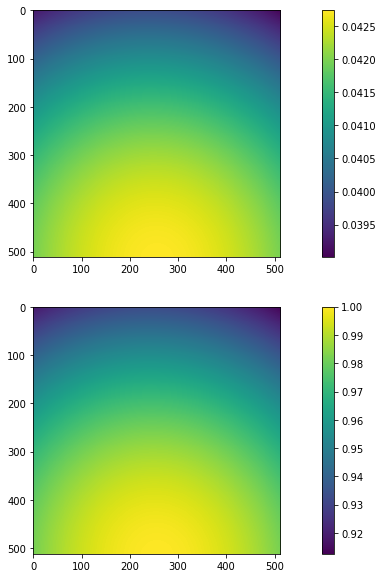

In [148]:
np.random.seed(seed=0)

invDim = (dim[1],dim[0])
# maxWidth = 500
maxCov = 15
nNorms = 3
xV = np.linspace(0,1,num= dim[0])
yV = np.linspace(0,1,num= dim[1])
xM, yM = np.meshgrid(xV,yV)
pos = np.dstack((xM, yM))

sumMap = np.zeros(invDim)
for i in range(nNorms):
    cent = np.random.uniform(-.5,1.5,size=(1,2))
    cov = np.zeros((2,2))
    # need to make a symmetric positive semidefinite covariance matrix
    cMaxCov = np.random.uniform(maxCov/2,maxCov,size=(1,1))
    cov = np.diag(np.random.uniform(cMaxCov/10,cMaxCov,size=(1,2)).flatten())
    maxCrCov = np.sqrt(np.product(np.diag(cov)))
    cov[[0,1],[1,0]] = np.random.uniform(-maxCrCov*.2,maxCrCov*.2) 
    rv = multivariate_normal(cent.flatten(), cov)
    sumMap += (rv.pdf(pos))
#     print((cMaxCov * 2 * np.pi))
#     sumMap += (rv.pdf(pos) * (np.dot(np.diag(cov),np.diag(cov)) * 2 * np.pi))
# print(pos)

fig2 = plt.figure(figsize=(15,10))
ax2 = fig2.add_subplot(211)
# plt.contourf(xV, yV, rv.pdf(pos))
plt.imshow(sumMap)
plt.colorbar()

nSumMap = sumMap / np.amax(sumMap,axis=(0,1))
ax2 = fig2.add_subplot(212)
# plt.contourf(xV, yV, rv.pdf(pos))
plt.imshow(nSumMap)
plt.colorbar()
               
plt.show()

In [113]:
xV = np.linspace(-1,1,num= dim[0])
yV = np.linspace(-1,1,num= dim[1])


682.0 [  0.         388.49581722 682.35632835]


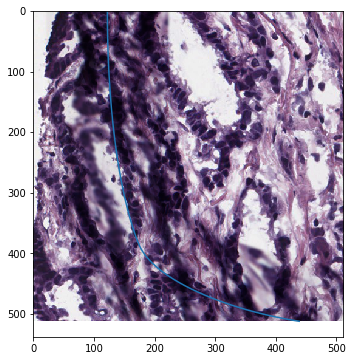

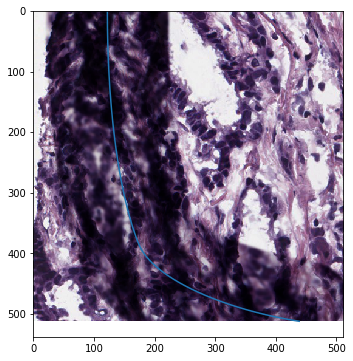

In [7]:
# samplePts = np.array([[400,0],[350,150],[450,512]])
# # print(len(samplePts),len(None))
# sampSpl = img_manip.rand_spline(dim, inPts=samplePts,random_seed = 0)
sampSpl = img_manip.rand_spline(dim, endEdge = -2, nPts=3,random_seed = 4)

comb_layer = img_manip.add_fold(im, sampSpl=sampSpl,random_seed = 0,nLayers = 1)
comb_layer2 = img_manip.add_fold(im, sampSpl=sampSpl,random_seed = 0,nLayers = 2)
    
fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(comb_layer)
plt.plot(sampSpl[:,0],sampSpl[:,1])
plt.show()

fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(comb_layer2)
plt.plot(sampSpl[:,0],sampSpl[:,1])
plt.show()

533.0 [  0.         158.11388301 533.67213415]


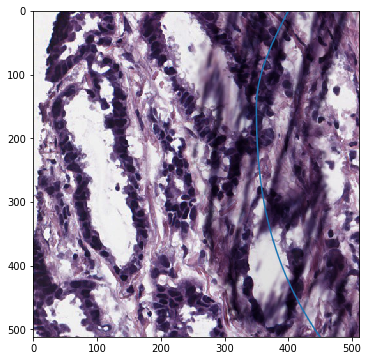

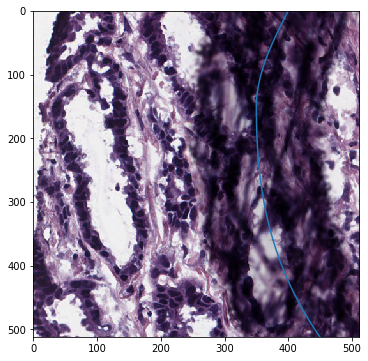

In [4]:
samplePts = np.array([[400,0],[350,150],[450,512]])
# print(len(samplePts),len(None))
sampSpl = img_manip.rand_spline(dim, inPts=samplePts,random_seed = 0)

comb_layer = img_manip.add_fold(im, sampSpl=sampSpl,random_seed = 0,nLayers = 1,randEdge=True)
comb_layer2 = img_manip.add_fold(im, sampSpl=sampSpl,random_seed = 0,nLayers = 2,randEdge=True)
    
fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(comb_layer)
plt.plot(sampSpl[:,0],sampSpl[:,1])
plt.show()

fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(comb_layer2)
plt.plot(sampSpl[:,0],sampSpl[:,1])
plt.show()

[[477.78093822 511.87505471]]


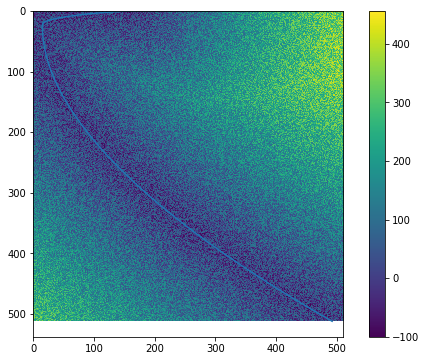

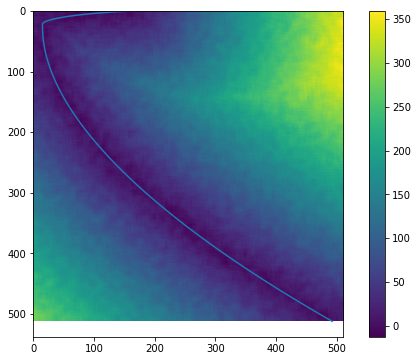

In [7]:
fold_width = 100
scaleXY = [1,1]
randEdge=True
input_im = im
im_arr = np.array(input_im)
dim = input_im.size # width by height
invDim = (dim[1],dim[0]) # have to invert the size dim because rows cols is yx vs xy

if sampSpl is None:
    if inPts is None:
        sampSpl = rand_spline(dim, inPts = inPts,random_seed = random_seed)
    else:
        sampSpl = rand_spline(dim, nPts = 3,random_seed = random_seed)

# if samp_arr is None:
samp_arr = np.copy(im_arr)

# if samp_shiftXY is None: # randomly initialized if empty
shiftXY = np.random.randint(-int(dim[0]/2),int(dim[0]/2),size=(2,1))
# else:
#     shiftXY = samp_shiftXY


pad_szXY = (512,512,0) # pad x, pad y, no pad z (have to reshape for np.pad, which takes y,x,z)
sampBlur = (int(fold_width/10),int(fold_width/10))
#     scaleXY = [2/3, 1]

pad_amt = np.transpose(np.tile(np.array(pad_szXY)[[1,0,2]],(2,1)))
samp_pad_arr = np.pad(samp_arr,pad_amt,mode='symmetric')

sampSplBBox = np.vstack((np.amin(sampSpl,axis=0),np.amax(sampSpl,axis=0)))
sampSplBBSz = np.diff(sampSplBBox,axis=0)
rsSplBBox = np.zeros((2,2))

signTup = (-1,1)
for di in range(2):
    rsSplBBox[di,:] = np.mean(sampSplBBox,axis=0) + (((sampSplBBSz/2) / scaleXY) * signTup[di])

rsSplBBSz = np.diff(rsSplBBox,axis=0)

sampSplBBPts = np.zeros((4,2),dtype=np.float32)
outBBPts = np.zeros((4,2),dtype=np.float32)
print(rsSplBBSz)

for di in range(sampSplBBPts.shape[0]):    
    LR_v_TB = di % 2 # left/right vs top/bottom
    LT_V_RB = di // 2 # left/top vs right/bottom
    sampSplBBPts[di,0] = sampSplBBox[LR_v_TB,0]
    sampSplBBPts[di,1] = sampSplBBox[LT_V_RB,1]
    outBBPts[di,0] = rsSplBBox[LR_v_TB,0] + pad_szXY[0] + shiftXY[0]
    outBBPts[di,1] = rsSplBBox[LT_V_RB,1] + pad_szXY[1] + shiftXY[1]

M = cv2.getPerspectiveTransform(outBBPts,sampSplBBPts)

warp_im = cv2.warpPerspective(samp_pad_arr,M,dim)

#
mask = np.ones(dim)
mask[(sampSpl[:,1].astype(int)),sampSpl[:,0].astype(int)] = 0
bw_dist = morphology.distance_transform_edt(mask)
if randEdge == True:
    distRand = np.random.randint(-int(fold_width),int(fold_width),size=invDim)
    
#     bw_rand = np.tile(distRand + bw_dist,(1,1,3))
    bw_rand = distRand + bw_dist
#     bw_rand = np.transpose(np.tile(temp,(3,1,1)),axes=(1,2,0))
    
#     print(bw_rand.shape,temp.shape)
    bw_blur = cv2.blur(bw_rand,(int(fold_width/8),int(fold_width/8)))
bw_rand = distRand + bw_dist
fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(bw_rand)
plt.colorbar()
plt.plot(sampSpl[:,0],sampSpl[:,1])
plt.show()

# bw_blur = medfilt(bw_rand,kernel_size=11)
fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(bw_blur)
plt.colorbar()
plt.plot(sampSpl[:,0],sampSpl[:,1])
plt.show()

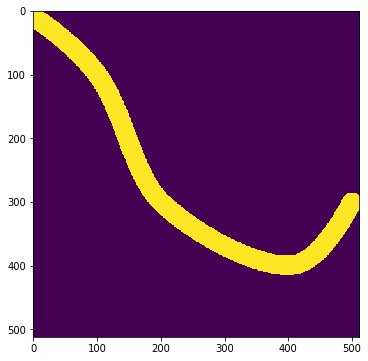

[[  0.          10.        ]
 [  0.85414647  10.58487923]
 [  1.70753889  11.17097775]
 ...
 [498.6199926  302.49987435]
 [499.25616617 301.35009327]
 [499.89135836 300.19757177]]


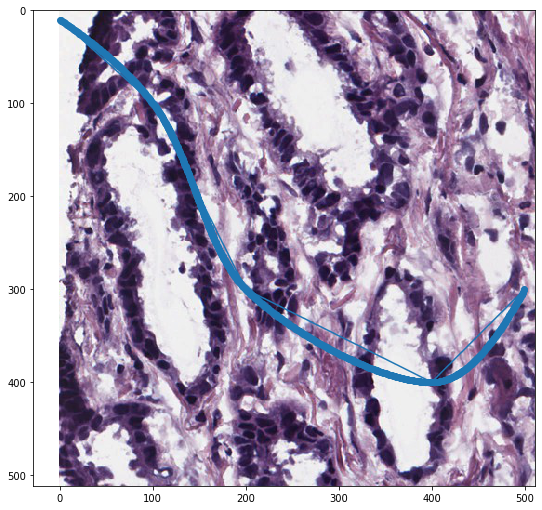

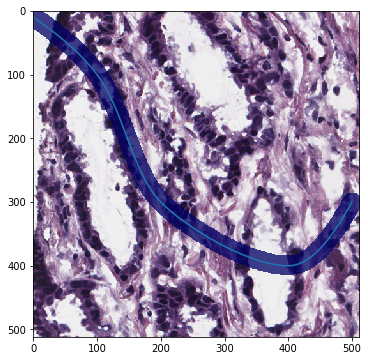

In [6]:
# from scipy import interpolate
XYpts = np.array([[0,10],[100,100],[200,300],[400,400],[500,300]])
distXY = np.sqrt(np.sum(np.diff(XYpts,axis=0)**2,axis=1))
# cdXY = np.zeros((1,1))
# cdXY.append(np.cumsum(distXY))

cdXY = np.concatenate((np.zeros((1)),np.cumsum(distXY)),axis=0)
iDist = np.arange(np.floor(cdXY[-1])+1)
intXY = interpolate.pchip_interpolate(cdXY,XYpts,iDist)
# print(cdXY)
# print(intXY)
mask = np.ones(dim)
mask[(intXY[:,1].astype(int)),intXY[:,0].astype(int)] = 0
bw_dist = morphology.distance_transform_edt(mask)
# print(cdXY)

thresh = 15
alpha = .75
bw_reg = bw_dist <= thresh
im_rgba = im.convert("RGBA")
alpha_mask = Image.fromarray((bw_reg*alpha*255).astype(np.uint8),'L')
color_arr = np.zeros((dim[0],dim[1],3),dtype=np.uint8)
rgbVal = (0,0,100)
for i in range(len(rgbVal)):
    color_arr[:,:,i] = rgbVal[i]
color_layer = Image.fromarray(color_arr,'RGB')

comp_im = Image.composite(color_layer, im_rgba, alpha_mask)

fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(alpha_mask)
plt.show()

# print(np.asarray(alpha_mask))
# fig,ax = plt.subplots(figsize=(9, 6))
# plt.imshow(color_layer)
# # plt.plot(XYpts[:,0],XYpts[:,1])
# plt.plot(intXY[:,0],intXY[:,1])
# # plt.scatter(intXY[:,0],intXY[:,1])
# plt.show()

print(intXY)
fig,ax = plt.subplots(figsize=(9, 9))
plt.imshow(im)
plt.plot(XYpts[:,0],XYpts[:,1])
plt.scatter(intXY[:,0],intXY[:,1])
plt.show()

# fig,ax = plt.subplots(figsize=(9, 6))
# plt.imshow(bw_dist)
# plt.plot(XYpts[:,0],XYpts[:,1])
# # plt.scatter(intXY[:,0],intXY[:,1])
# plt.show()
fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(comp_im)
# plt.plot(inXY[:,0],inXY[:,1])
plt.plot(intXY[:,0],intXY[:,1])
# plt.scatter(intXY[:,0],intXY[:,1])
plt.show()

(512, 512)
[[172   0]
 [ 47 251]
 [117 195]
 [192 512]]


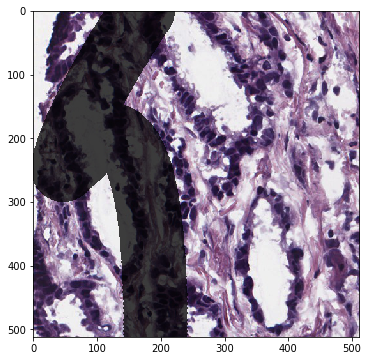

In [7]:
np.random.seed(seed=0)
startEdge = True
endEdge = True
nPts = 4
print(dim)
invDim = (dim[1],dim[0]) # have to invert the size dim because rows cols is yx vs xy
# if startEdge == True:
#     edgeNum = np.random.randint(4)
# for edgeNum in range(4):
#     LR_v_TB = edgeNum % 2 # left/right vs top/bottom
#     LT_V_RB = edgeNum // 2 # left/top vs right/bottom

#     coord = np.random.randint(invDim[LR_v_TB],size=(1,2))
# #     print(coord)
#     coord[0,LR_v_TB] = LT_V_RB * invDim[LR_v_TB]-1 # one edge or the other
# print(LR_v_TB,LT_V_RB,coord)
# LR_v_TB = edgeNum % 2 # left/right vs top/bottom
# LT_V_RB = edgeNum // 2 # left/top vs right/bottom
outPts = np.concatenate((np.random.randint(invDim[0],size=(nPts,1)),
                         np.random.randint(invDim[1],size=(nPts,1))),
                        axis=1)
if startEdge == True:
    edgeNum = np.random.randint(4)
    LR_v_TB = edgeNum % 2 # left/right vs top/bottom
    LT_V_RB = edgeNum // 2 # left/top vs right/bottom
    outPts[0,LR_v_TB] = LT_V_RB * invDim[LR_v_TB] # one edge or the other
# print(nPts-1,LR_v_TB,outPts.shape)
if endEdge == True:
    edgeNum = np.random.randint(4)
    LR_v_TB = edgeNum % 2 # left/right vs top/bottom
    LT_V_RB = edgeNum // 2 # left/top vs right/bottom
    outPts[nPts-1,LR_v_TB] = LT_V_RB * invDim[LR_v_TB] # one edge or the other
    

print(outPts)

distXY = np.sqrt(np.sum(np.diff(outPts,axis=0)**2,axis=1))

cdXY = np.concatenate((np.zeros((1)),np.cumsum(distXY)),axis=0)
iDist = np.arange(np.floor(cdXY[-1])+1)
intXY = interpolate.pchip_interpolate(cdXY,outPts,iDist)
# print(cdXY)
# print(intXY)
mask = np.ones(dim)
mask[(intXY[:,1].astype(int)),intXY[:,0].astype(int)] = 0
bw_dist = morphology.distance_transform_edt(mask)
# print(cdXY)

thresh = 50
alpha = .75
bw_reg = bw_dist <= thresh
im_rgba = im.convert("RGBA")
alpha_mask = Image.fromarray((bw_reg*alpha*255).astype(np.uint8),'L')
color_arr = np.zeros((dim[0],dim[1],3),dtype=np.uint8)
rgbVal = (0,0,0)
for i in range(len(rgbVal)):
    color_arr[:,:,i] = rgbVal[i]
color_layer = Image.fromarray(color_arr,'RGB')

comp_im = Image.composite(color_layer, im_rgba, alpha_mask)
# XYpts = np.array([[0,10],[100,100],[200,300],[400,400],[500,300]])
fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(comp_im)
# plt.plot(inXY[:,0],inXY[:,1])
# plt.plot(intXY[:,0],intXY[:,1])
# plt.scatter(intXY[:,0],intXY[:,1])
plt.show()

1135.0 [   0.          170.60187572  527.53324167  743.007138    889.69387906
 1135.47630316]


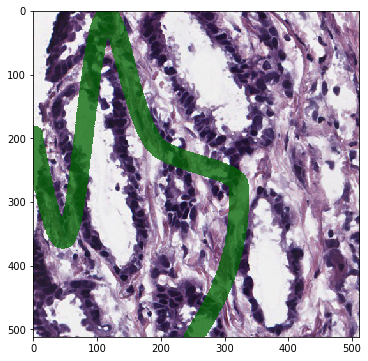

In [8]:
splXY = img_manip.rand_spline(dim, nPts = 6,random_seed = 0)
thresh = 15
alpha = .75

mask = np.ones(dim)
mask[(splXY[:,1].astype(int)),splXY[:,0].astype(int)] = 0
bw_dist = morphology.distance_transform_edt(mask)

bw_reg = bw_dist <= thresh
im_rgba = im.convert("RGBA")
alpha_mask = Image.fromarray((bw_reg*alpha*255).astype(np.uint8),'L')
color_arr = np.zeros((dim[0],dim[1],3),dtype=np.uint8)
rgbVal = (0,100,0)
for i in range(len(rgbVal)):
    color_arr[:,:,i] = rgbVal[i]
color_layer = Image.fromarray(color_arr,'RGB')

comp_im = Image.composite(color_layer, im_rgba, alpha_mask)
fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(comp_im)
# plt.plot(splXY[:,0],splXY[:,1])
plt.show()

[[ 49.77306923 255.67247477]] 0.6666666666666666 -1
[[ 49.77306923 255.67247477]] 1 1
[[350.00003771   0.        ]
 [449.54617618 511.34494955]]
[[325.1135031    0.        ]
 [474.4327108  511.34494955]]


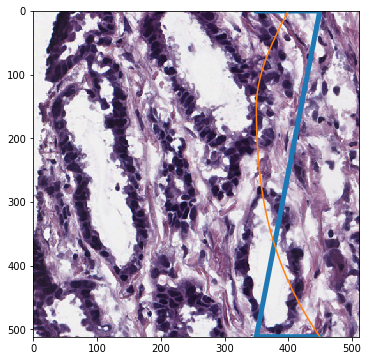

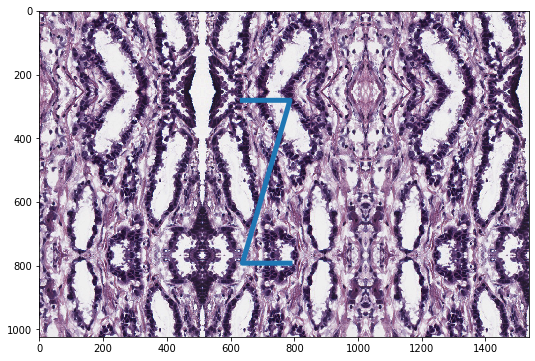

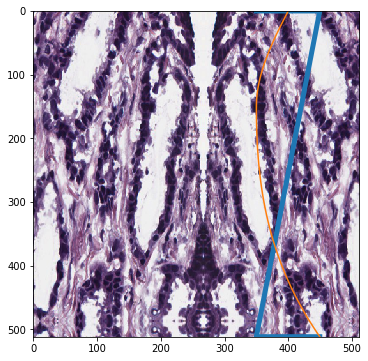

In [13]:
im_arr = np.array(im)
dim = im.size
pad_sz = (512,256,0) # pad x, pad y, no pad z (have to reshape for np.pad, which takes y,x,z)
pad_amt = np.transpose(np.tile(np.array(pad_sz)[[1,0,2]],(2,1)))
# print(pad_amt)
im_pad_arr = np.pad(im_arr,pad_amt,mode='symmetric')
# fig,ax = plt.subplots(figsize=(9, 6))
# plt.imshow(im_pad_arr)
# # plt.plot(sampSpl[:,0],sampSpl[:,1])
# # plt.colorbar()
# plt.show()

# fig,ax = plt.subplots(figsize=(9, 6))
# plt.imshow(im_pad_arr[pad_sz[0]:pad_sz[0]+invDim[0],pad_sz[1]:pad_sz[1]+invDim[1]])
# # plt.plot(sampSpl[:,0],sampSpl[:,1])
# # plt.colorbar()
# plt.show()

sampSplBBox = np.vstack((np.amin(sampSpl,axis=0),np.amax(sampSpl,axis=0)))
sampSplBBSz = np.diff(sampSplBBox,axis=0)
rsSplBBox = np.zeros((2,2))
scaleXY = [2/3, 1]
signTup = (-1,1)
shiftXY = [-200,25]
for di in range(2):
    rsSplBBox[di,:] = np.mean(sampSplBBox,axis=0) + (((sampSplBBSz/2) / scaleXY) * signTup[di])
    print(sampSplBBSz/2,scaleXY[di],signTup[di])
# print(sampSplBBSz)
print(sampSplBBox)
print(rsSplBBox)
sampSplBBPts = np.zeros((4,2),dtype=np.float32)
outBBPts = np.zeros((4,2),dtype=np.float32)
# print(sampSplBBox)
for di in range(sampSplBBPts.shape[0]):    
    LR_v_TB = di % 2 # left/right vs top/bottom
    LT_V_RB = di // 2 # left/top vs right/bottom
    sampSplBBPts[di,0] = sampSplBBox[LR_v_TB,0]
    sampSplBBPts[di,1] = sampSplBBox[LT_V_RB,1]
    outBBPts[di,0] = rsSplBBox[LR_v_TB,0] + pad_sz[0] + shiftXY[0]
    outBBPts[di,1] = rsSplBBox[LT_V_RB,1] + pad_sz[1] + shiftXY[1]
# print(sampSplBBPts)
# print(outBBPts)

M = cv2.getPerspectiveTransform(outBBPts,sampSplBBPts)

fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(im_arr)
plt.plot(sampSplBBPts[:,0],sampSplBBPts[:,1],linewidth=5)
plt.plot(sampSpl[:,0],sampSpl[:,1])
plt.show()


dst = cv2.warpPerspective(im_pad_arr,M,invDim)
fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(im_pad_arr)
plt.plot(outBBPts[:,0],outBBPts[:,1],linewidth=5)
plt.show()

fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(dst)
plt.plot(sampSplBBPts[:,0],sampSplBBPts[:,1],linewidth=5)
plt.plot(sampSpl[:,0],sampSpl[:,1])
plt.show()

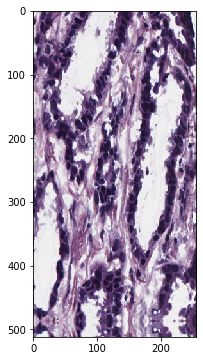

In [148]:
dst = cv2.warpPerspective(im_pad_arr,M,(256,512))

fig,ax = plt.subplots(figsize=(9, 6))
plt.imshow(dst)
plt.show()

In [15]:
startEdge = 2
print(startEdge in range(0,4))
print(-4 in range(-4,0))

print(-1 in range(-4,0))

print(0 in range(-4,0))

True
True
True
False
